In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import seaborn as sns

# Cleaning and Analysis

In [2]:
df1 = pd.read_csv('takehome_user_engagement.csv', encoding='latin1')
df2 = pd.read_csv('takehome_users.csv', encoding='latin1')

In [3]:
df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df1['visited'].unique

<bound method Series.unique of 0         1
1         1
2         1
3         1
4         1
         ..
207912    1
207913    1
207914    1
207915    1
207916    1
Name: visited, Length: 207917, dtype: int64>

In [5]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
df1.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [7]:
df2.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [8]:
df2.shape

(12000, 10)

In [9]:
df1.shape

(207917, 3)

In [10]:
df1.rename(columns={'time_stamp':'date', 'user_id':'id'}, inplace=True)
df1.head(1)

,date,id,visited
0,2014-04-22 03:53:30,1,1


In [11]:
df2.rename(columns={'creation_time':'date', 'object_id':'id'}, inplace=True)
df2.head(1)

,id,date,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0


I'm removing columns that won't help in predicting if a user is an adopted user. 

In [13]:
df2.drop(['name', 'email'], axis=1, inplace=True) 

In [14]:
df = pd.merge(df1, df2, on=['date', 'id'], how='outer')
df.head()

,date,id,visited,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2012-05-31 00:43:27,3861,NaN,ORG_INVITE,1.338684e+09,0.0,0.0,115.0,3861.0
1,2012-05-31 01:42:31,11430,NaN,ORG_INVITE,1.338515e+09,0.0,0.0,239.0,5677.0
2,2012-05-31 06:23:51,7170,NaN,ORG_INVITE,1.345444e+09,0.0,0.0,145.0,7170.0
3,2012-05-31 08:20:06,10012,1.0,ORG_INVITE,1.338452e+09,0.0,1.0,225.0,7104.0
4,2012-05-31 11:55:59,11999,NaN,PERSONAL_PROJECTS,1.338638e+09,0.0,0.0,6.0,NaN


In [15]:
df.shape

(215567, 9)

In [16]:
df.isnull().sum()

date                               0
id                                 0
visited                         7650
creation_source               203567
last_session_creation_time    206744
opted_in_to_mailing_list      203567
enabled_for_marketing_drip    203567
org_id                        203567
invited_by_user_id            209150
dtype: int64

In [17]:
df.fillna(0, inplace=True)

In [18]:
df.isnull().sum()

date                          0
id                            0
visited                       0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

In [19]:
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['id', 'date'])

def flag_adopted(group):
    group = group.copy()
    group = group.set_index('date')
    group['visit_count'] = group['id'].rolling('7D').count()
    group['adopted'] = (group['visit_count'] >= 3).astype(int)
    group = group.reset_index()
    return group

df = df.groupby('id', group_keys=False).apply(flag_adopted)

user_adopted = df.groupby('id')['adopted'].max().reset_index()
print(user_adopted.head())


   id  adopted
0   1        0
1   2        1
2   3        0
3   4        0
4   5        0


C:\Users\Miranda\AppData\Local\Temp\ipykernel_28824\3387651590.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('id', group_keys=False).apply(flag_adopted)


In [20]:
df.head()

,date,id,visited,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visit_count,adopted
0,2014-04-22 03:53:30,1,1.0,GUEST_INVITE,1.398139e+09,1.0,0.0,11.0,10803.0,1.0,0
0,2013-11-15 03:45:04,2,1.0,ORG_INVITE,1.396238e+09,0.0,0.0,1.0,316.0,1.0,0
1,2013-11-29 03:45:04,2,1.0,0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0
2,2013-12-09 03:45:04,2,1.0,0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0
3,2013-12-25 03:45:04,2,1.0,0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0


In [21]:
df.isnull().sum()

date                          0
id                            0
visited                       0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
visit_count                   0
adopted                       0
dtype: int64

In [22]:
df['creation_source'] = df['creation_source'].astype('category').cat.codes


In [23]:
df.head()

,date,id,visited,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visit_count,adopted
0,2014-04-22 03:53:30,1,1.0,1,1.398139e+09,1.0,0.0,11.0,10803.0,1.0,0
0,2013-11-15 03:45:04,2,1.0,2,1.396238e+09,0.0,0.0,1.0,316.0,1.0,0
1,2013-11-29 03:45:04,2,1.0,0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0
2,2013-12-09 03:45:04,2,1.0,0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0
3,2013-12-25 03:45:04,2,1.0,0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0


In [24]:
df.dtypes

date                          datetime64[ns]
id                                     int64
visited                              float64
creation_source                         int8
last_session_creation_time           float64
opted_in_to_mailing_list             float64
enabled_for_marketing_drip           float64
org_id                               float64
invited_by_user_id                   float64
visit_count                          float64
adopted                                int32
dtype: object

In [25]:
df.drop('visited', axis=1, inplace=True)

In [26]:
df.drop('visit_count', axis=1, inplace=True)

In [27]:
df['adopted'].unique()

array([0, 1])

Awesome, all columns are numeric. Time to scale the non categorical data. 

In [29]:
cat_cols = ['id', 'creation_source', 'enabled_for_to_marketing_drip', 'opted_in_to_mailing_list', 'org_id', 'adopted', 'date']
num_cols = [col for col in df.columns if col not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'  
)


In [30]:
X = df.drop(['adopted', 'date'], axis=1)
y = df['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.1568940852681206
R-squared: 0.16656193697291588


In [31]:
model2 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.19511244711645515
R-squared: -0.03645806481051839


In [32]:
param_grid = {
   'n_estimators': [100, 200, 300],
   'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': None, 'n_estimators': 300}


In [33]:
model3 = model2 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(max_depth=None, n_estimators=100))
])
model3.fit(X_train, y_train)

y_pred = model3.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.15067171379796632
R-squared: 0.19961583582868192


In [34]:
model4 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

In [35]:
model5 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])


In [36]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n" + "-"*40 + "\n")

In [37]:
print("XGBoost Results")
evaluate_model(model4, X_train, X_test, y_train, y_test)

XGBoost Results


C:\Users\Miranda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:08:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8048875528835449
F1 Score: 0.8846925683455604
ROC-AUC: 0.7206523361072451
Confusion Matrix:
 [[ 3039 10515]
 [    0 40338]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.37     13554
           1       0.79      1.00      0.88     40338

    accuracy                           0.80     53892
   macro avg       0.90      0.61      0.63     53892
weighted avg       0.85      0.80      0.75     53892


----------------------------------------



In [38]:
print("LightGBM Results")
evaluate_model(model5, X_train, X_test, y_train, y_test)

LightGBM Results
[LightGBM] [Info] Number of positive: 120516, number of negative: 41159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 161675, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745421 -> initscore=1.074340
[LightGBM] [Info] Start training from score 1.074340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

The results for these last three models do work better than the previous 3 models, but they are generalizing. The data has many adopted (1), more than non adopted (0). This made the models learn to predict the user as adopted. Let's change the weights in the next model(s).  

In [46]:
num_class0 = (y_train == 0).sum()
num_class1 = (y_train == 1).sum()

In [48]:
model6= Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(num_class0 / num_class1), 
        random_state=42
    ))
])

In [50]:
print("XGBoost Results")
evaluate_model(model6, X_train, X_test, y_train, y_test)

XGBoost Results
[LightGBM] [Info] Number of positive: 120516, number of negative: 41159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 161675, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745421 -> initscore=1.074340
[LightGBM] [Info] Start training from score 1.074340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

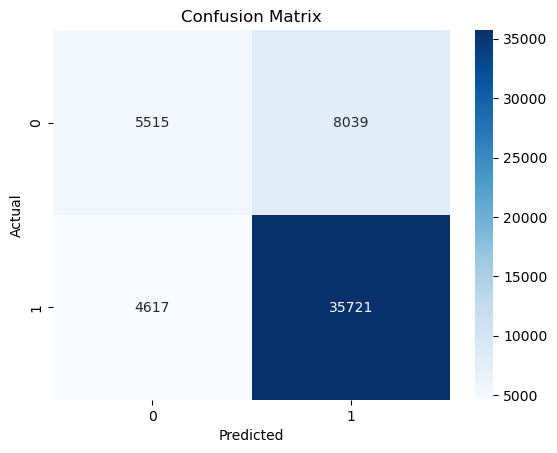

In [51]:
y_pred = model6.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [52]:
model7 =  Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(num_class0 / num_class1), 
        random_state=42
    ))
])

In [53]:
print("XGBoost Results")
evaluate_model(model7, X_train, X_test, y_train, y_test)

XGBoost Results


C:\Users\Miranda\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:10:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7715801974319009
F1 Score: 0.8557162615157411
ROC-AUC: 0.721203732218106
Confusion Matrix:
 [[ 5078  8476]
 [ 3834 36504]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.37      0.45     13554
           1       0.81      0.90      0.86     40338

    accuracy                           0.77     53892
   macro avg       0.69      0.64      0.65     53892
weighted avg       0.75      0.77      0.75     53892


----------------------------------------



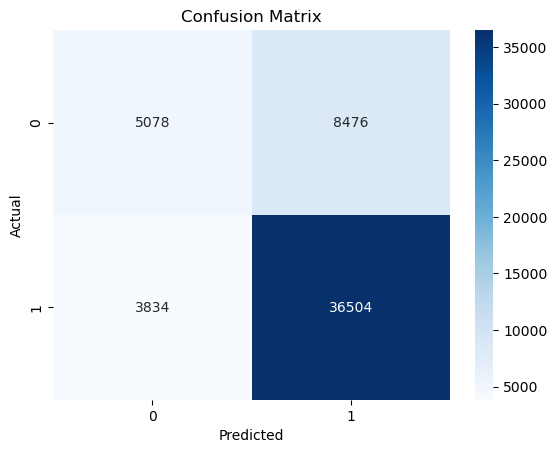

In [58]:
y_pred = model7.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

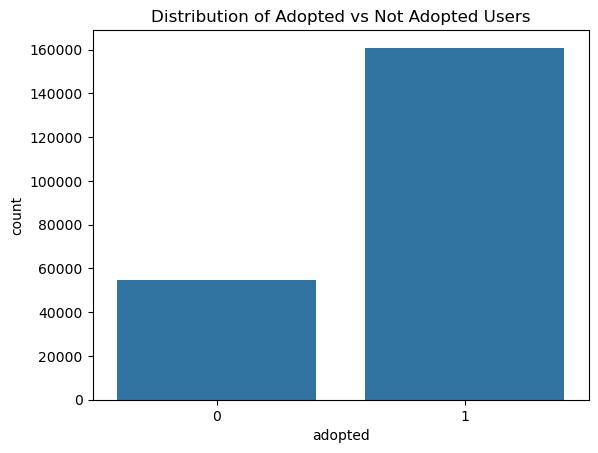

In [60]:
sns.countplot(x='adopted', data=df)
plt.title("Distribution of Adopted vs Not Adopted Users")
plt.show()

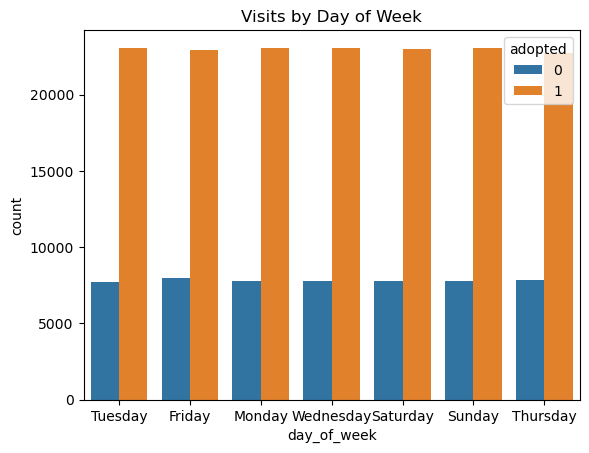

In [61]:
df['day_of_week'] = df['date'].dt.day_name()
sns.countplot(x='day_of_week', hue='adopted', data=df)
plt.title("Visits by Day of Week")
plt.show()

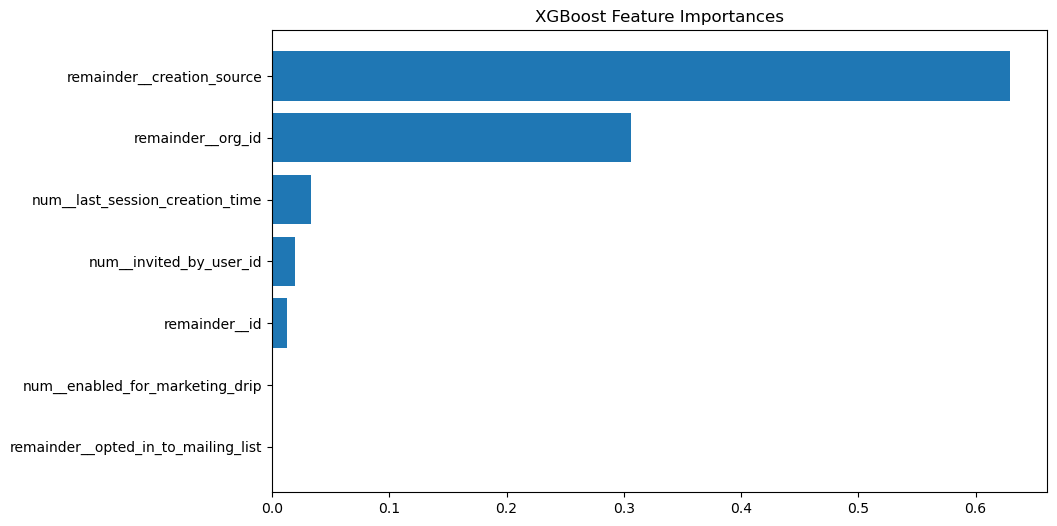

In [74]:
xgb_model = model7.named_steps['classifier']

feature_names = model7.named_steps['preprocessor'].get_feature_names_out()

importances = xgb_model.feature_importances_

feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feat_importance['feature'], feat_importance['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.show()


Remainder is from when we scaled the data. Remainder is attached to columns that were passed through. 

# Summary

Site visits seem to be fairly evenly distributed. Adoption rates, however, are strongly influenced by how users received their account invitation — either through an organization or as a guest invitation. The models predicted adopted user rates, but scoring shows evidence of imbalance, as adopted user is very high. Since the majority of users are adopted, the model tends to predict adoption for most cases, reflecting the skewed distribution rather than nuanced differences between users. More data would improve in future analyses. As I was cleaning the data, I had to fill in many missing values with the median of their column, while filling categorical columns with zero. 